**AutoEncoder**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
EPOCH = 10
batch_size = 64
LR = 0.005      
DOWNLOAD_MNIST = False
### Number of images we want to test on
N_TEST_IMG = 100

In [3]:
#Loading the train set file
train_data = dsets.MNIST(root='../data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)
#Loading the test set file
test_data = dsets.MNIST(root='../data', 
                           train=False, 
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



#### Visulaizing one of the training data

C:\Users\tenu0.LABRINTH\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\tenu0.LABRINTH\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


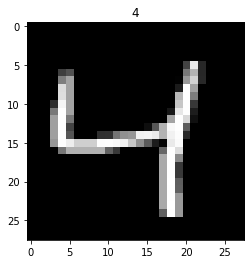

In [4]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [5]:
#loading the train dataset
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# loading the test dataset

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # activation functions
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            #activation functions
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.2329


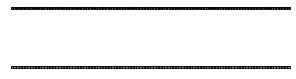

Epoch:  0 | train loss: 0.0574


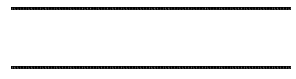

Epoch:  5 | train loss: 0.0351


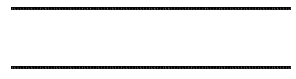

Epoch:  5 | train loss: 0.0407


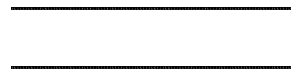

Epoch:  9 | train loss: 0.0328


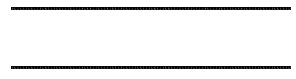

Epoch:  9 | train loss: 0.0368


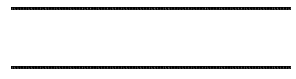

In [7]:
autoencoder = AutoEncoder()
print(autoencoder)

# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data)
            # plotting decoded image (second row)
            encoded_data, decoded_data = autoencoder(view_data)
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            #Plotting orginal images
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
            # Plotting the decoded images
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); 

In [8]:
autoencoder = AutoEncoder()
print(autoencoder)

# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for b_x in range(EPOCH):
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)
print(loss)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


C:\Users\tenu0.LABRINTH\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


tensor(0.2306, grad_fn=<MseLossBackward0>)


In [9]:
from sklearn.decomposition import PCA
import numpy as np
# Reconstruct original data
# Perform PCA for three components
pca = PCA(3)
loss = 0
for step, (x, y) in enumerate(test_loader):
        b_x = (x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28))
        b_x = np.array(b_x)
        b_y = np.array(b_y)
        data_reduced = pca.fit_transform(b_x)
        data_reconstructed = pca.inverse_transform(data_reduced)
        #loss += ((abs(data_reconstructed) - (b_x)) ** 2)
        loss += ((b_x - data_reconstructed) ** 2).mean()
print(loss)

7.344843279570341
